In [1]:
require './moromoro'

true

In [2]:
(467.8 + 466.2)/2

467.0

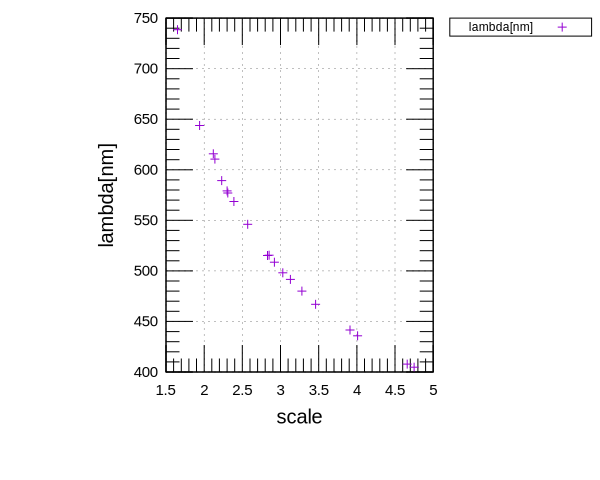

In [3]:
elem_dict = { 0 => 'Na', 1 => 'Hg', 2 => 'Cd' }
raw_data = <<DATA.to_df
scale, lambda[nm], element
2.23, 589.3, 0
2.30, 579.1, 1
2.31, 577.0, 1
2.57, 546.1, 1
4.01, 435.8, 1
1.94, 643.8, 2
2.92, 508.6, 2
1.65, 738.5, 2
2.14, 610.6, 2
2.85, 515.5, 2
3.28, 480.0, 2
3.46, 467.0, 2
3.91, 441.5, 2
2.12, 615.8, 0
2.39, 568.6, 0
3.03, 498.1, 0
2.83, 515.2, 0
3.13, 491.6, 1
4.66, 407.8, 1
4.75, 404.7, 1
DATA
variance_df = raw_data.map do |row|
  row.merge(
    'lambda_square_inverse[(nm)^2]' => 1.0/row['lambda[nm]']**2,
    'element' => elem_dict[row['element'].to_i]
  )
end.to_df
variance_df.plot(
  targets: [{x: 'scale', y: 'lambda[nm]' }]
)

In [4]:
variance_df.map do |row|
  { '{\\rm scale}': '%.2f' % row['scale'], '\\lambda[{\\rm nm}]': row['lambda[nm]'], '{\\rm element}': row['element'] }
end.reset.save_csv('csv/bunsan.csv')

"csv/bunsan.csv"

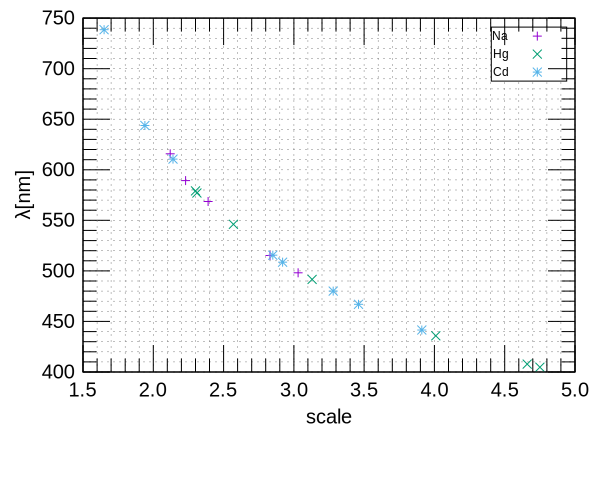

In [5]:
traces = variance_df.group_by { |row| row['element'] }.map do |element, rows|
  {xs: rows.to_df.by_col('scale'), ys: rows.to_df.by_col('lambda[nm]'), element: element }
end.map { |trace| [trace[:xs], trace[:ys], { title: trace[:element] }] }
<<COMMENT
  set 'arrow 1 from 1.87,400 to 1.87,750 nohead'
  set 'arrow 2 from 3.20,400 to 3.20,750 nohead'
  set 'arrow 3 from 4.05,400 to 4.05,750 nohead'
  set 'arrow 4 from 4.59,400 to 4.59,750 nohead'
  set 'arrow 5 from 1,434.1 to 5,434.1 nohead'
  set 'arrow 6 from 1,656.2 to 5,656.2 nohead'
  set 'arrow 7 from 1,486.1 to 5,486.1 nohead'
  set 'arrow 8 from 1,410.2 to 5,410.2 nohead'
COMMENT
plot = Proc.new do |plt, traces|
  plt.set tics: 'scale 3 font ",20"'
  plt.set mxtics: ''
  plt.set mytics: ''
  plt.set grid: 'xtics ytics mxtics mytics'
  plt.set key: 'box'
  plt.set xl: "'scale' font ',20'"
  plt.set yl: "'λ[nm]' font ',20'"
  plt.set 'format x': '"%.1f"'
  plt.set bmargin: 6
  plt.set lmargin: 10
  
  plt.plot *traces
end
Numo.gnuplot do
  set terminal: 'png'
  set output: 'graph/bunsan.png'
  plot.call(self, traces)
end
Numo.noteplot do
  plot.call(self, traces)
end

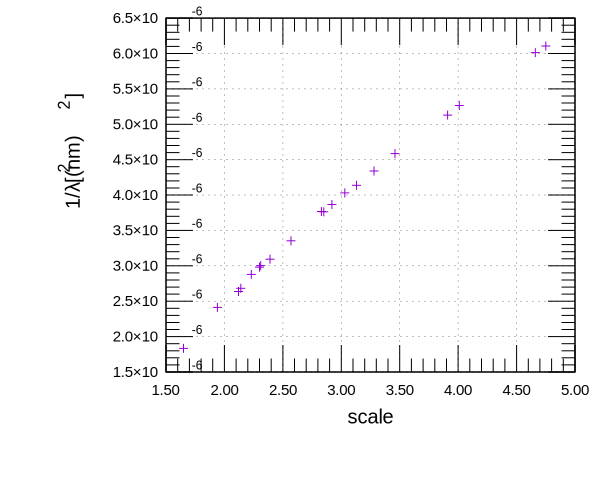

In [46]:
variance_df.map do |row|
  row.merge(
    '1/λ^2 [m^{-2}]' => 1/(row['lambda[nm]'] * 10**(-9))**2
  )
end.plot(
  targets: [{x: 'scale', y: '1/λ^2 [(nm)^2]' }],
  options: {
    nokey: '',
    'format x': '"%.2f"',
    'format y': '"%1.1t×10^{%L}"',
  },
  file: 'graph/lambda_square.png'
)

In [7]:
def plot_hdf(h_df)
  h_with_calc = h_df.map do |row|
    row.merge(
      'lambda_inverse' => 1/(row['lambda[nm]'] * 10**(-9)),
      'n_square_inverse' => 1/row['n']**2
    )
  end.reset

  slope = h_with_calc.slope(x: 'n_square_inverse', y: 'lambda_inverse')
  segment = p h_with_calc.segment(x: 'n_square_inverse', y: 'lambda_inverse')
  h_with_calc.map do |row|
    row.merge(
      '1/λ[m^{-1}]' => row['lambda_inverse'],
      '1/n^2' => row['n_square_inverse']
    )
  end.reset.plot(
    targets: [
      {x: '1/n^2', y: '1/λ[m^{-1}]'},
    ],
    options: {
      nokey: '',
      'format x': '"%.2f"',
      'format y': '"%1.1t×10^{%L}"',
      xtics: 'rotate by -90',
      xrange: '[0:0.3]',
      yrange: '[0:2500000]'
    }
  )
end

:plot_hdf

2080641.8478950006


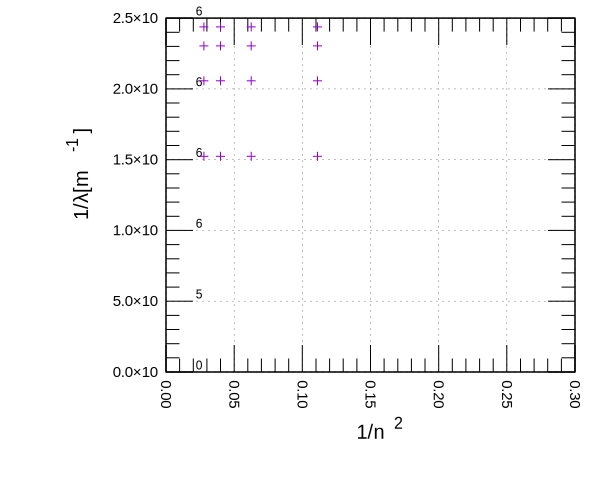

In [8]:
h_df_with_all_n = <<DATA.to_df
lambda[nm], scale, n
656.2, 1.87, 3
656.2, 1.87, 4
656.2, 1.87, 5
656.2, 1.87, 6
486.1, 3.20, 3
486.1, 3.20, 4
486.1, 3.20, 5
486.1, 3.20, 6
434.1, 4.05, 3
434.1, 4.05, 4
434.1, 4.05, 5
434.1, 4.05, 6
410.2, 4.59, 3
410.2, 4.59, 4
410.2, 4.59, 5
410.2, 4.59, 6
DATA

plot_hdf(h_df_with_all_n)

2756306.4169865325


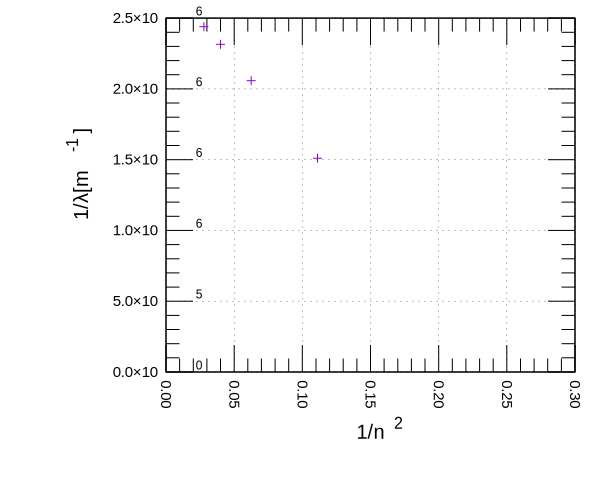

In [9]:
h_df = <<DATA.to_df
lambda[nm], scale, n
662, 1.87, 3
486, 3.20, 4
432, 4.05, 5
410, 4.59, 6
DATA

plot_hdf(h_df)

In [16]:
h_with_calc = h_df.map do |row|
  row = row.merge(
    'lambda_inverse' => 1/(row['lambda[nm]'] * 10**(-9)),
    'n_square_inverse' => 1/row['n']**2
  )
  puts '%.2e' % row['lambda_inverse']
  puts '%.3f' % row['n_square_inverse']
  row
end.reset

1.51e+06
0.111
2.06e+06
0.062
2.31e+06
0.040
2.44e+06
0.028


[{"lambda[nm]"=>662.0, "scale"=>1.87, "n"=>3.0, "lambda_inverse"=>1510574.018126888, "n_square_inverse"=>0.1111111111111111}, {"lambda[nm]"=>486.0, "scale"=>3.2, "n"=>4.0, "lambda_inverse"=>2057613.1687242799, "n_square_inverse"=>0.0625}, {"lambda[nm]"=>432.0, "scale"=>4.05, "n"=>5.0, "lambda_inverse"=>2314814.814814815, "n_square_inverse"=>0.04}, {"lambda[nm]"=>410.0, "scale"=>4.59, "n"=>6.0, "lambda_inverse"=>2439024.3902439023, "n_square_inverse"=>0.027777777777777776}]

2756306.4169865325


line 120: warning: Skipping data file with no valid points
line 130: warning: Skipping data file with no valid points


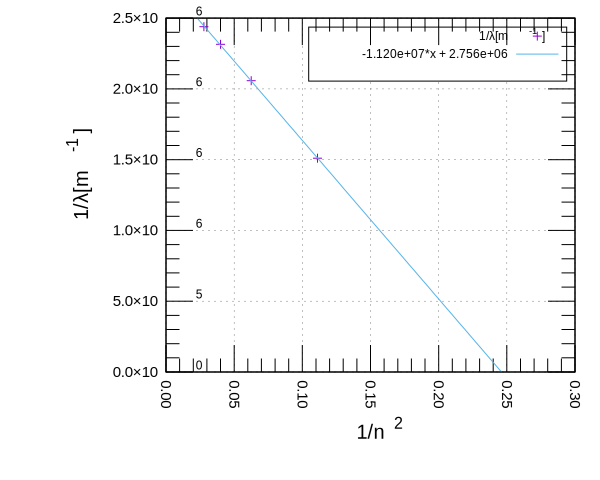

In [10]:
slope = h_with_calc.slope(x: 'n_square_inverse', y: 'lambda_inverse')
segment = p h_with_calc.segment(x: 'n_square_inverse', y: 'lambda_inverse')
h_with_calc.map do |row|
  row.merge(
    '1/λ[m^{-1}]' => row['lambda_inverse'],
    '1/n^2' => row['n_square_inverse']
  )
end.reset.plot(
  targets: [
    {x: '1/n^2', y: '1/λ[m^{-1}]'},
    {function: "#{'%.3e' % slope}*x + #{'%.3e' % segment}"},
  ],
  options: {
    key: 'box',
    'format x': '"%.2f"',
    'format y': '"%1.1t×10^{%L}"',
    xtics: 'rotate by -90',
    xrange: '[0:0.3]',
    yrange: '[0:2500000]'
  },
  file: 'graph/rydberg.png'
)

In [42]:
'%.2e' % ((2.6 * 10**6) / (0.01 - 0.25))

"-1.08e+07"

In [43]:
'%.2e' % ((2.64 * 10**6) / (0.01 - 0.25))

"-1.10e+07"

In [44]:
'%.2e' % ((2.67 * 10**6) / (0.01 - 0.25))

"-1.11e+07"

In [38]:
(1.15 - 1.096)/1.15

0.046956521739130286

In [39]:
2.75 * 4

11.0

In [40]:
0.04 * 4

0.16